# Bayesian Hierarchical Linear Regression
Author: [Carlos Souza](mailto:souza@gatech.edu)

Updated by: [Chris Stoafer](mailto:cstoafer@gmail.com)

Probabilistic Machine Learning models can not only make predictions about future data, but also **model uncertainty**. In areas such as **personalized medicine**, there might be a large amount of data, but there is still a relatively **small amount of data for each patient**. To customize predictions for each person it becomes necessary to **build a model for each person** — with its inherent **uncertainties** — and to couple these models together in a **hierarchy** so that information can be borrowed from other **similar people** [1].

The purpose of this tutorial is to demonstrate how to **implement a Bayesian Hierarchical Linear Regression model using NumPyro**. To motivate the tutorial, I will use [OSIC Pulmonary Fibrosis Progression](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression) competition, hosted at Kaggle.

## 1. Understanding the task
Pulmonary fibrosis is a disorder with no known cause and no known cure, created by scarring of the lungs. In this competition, we were asked to predict a patient’s severity of decline in lung function. Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled.

In medical applications, it is useful to **evaluate a model's confidence in its decisions**. Accordingly, the metric used to rank the teams was designed to reflect **both the accuracy and certainty of each prediction**. It's a modified version of the Laplace Log Likelihood (more details on that later).

Let's explore the data and see what's that all about:

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In the dataset, we were provided with a baseline chest CT scan and associated clinical information for a set of patients. A patient has an image acquired at time Week = 0 and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured. For this tutorial, I will use only the Patient ID, the weeks and the FVC measurements, discarding all the rest. Using only these columns enabled our team to achieve a competitive score, which shows the power of Bayesian hierarchical linear regression models especially when gauging uncertainty is an important part of the problem.

Since this is real medical data, the relative timing of FVC measurements varies widely, as shown in the 3 sample patients below:

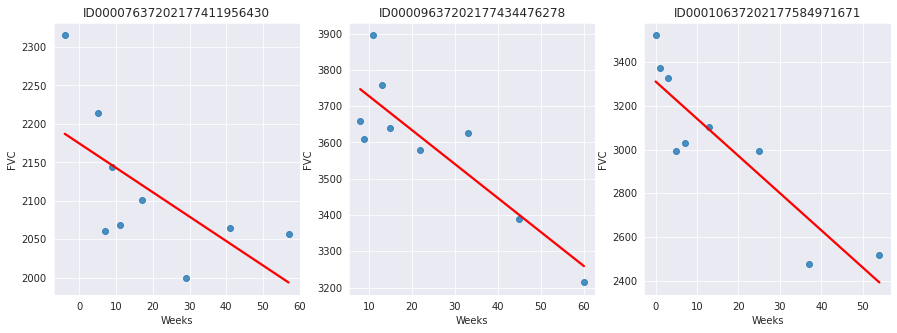

In [4]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient("ID00007637202177411956430", axes[0])
chart_patient("ID00009637202177434476278", axes[1])
chart_patient("ID00010637202177584971671", axes[2])

On average, each of the 176 provided patients made 9 visits, when FVC was measured. The visits happened in specific weeks in the [-12, 133] interval. The decline in lung capacity is very clear. We see, though, they are very different from patient to patient.

We were are asked to predict every patient's FVC measurement for every possible week in the [-12, 133] interval, and the confidence for each prediction. In other words: we were asked fill a matrix like the one below, and provide a confidence score for each prediction:

<img src="https://i.ibb.co/0Z9kW8H/matrix-completion.jpg" alt="drawing" width="600"/>

The task was perfect to apply Bayesian inference. However, the vast majority of solutions shared by Kaggle community used discriminative machine learning models, disconsidering the fact that most discriminative methods are very poor at providing realistic uncertainty estimates. Because they are typically trained in a manner that optimizes the parameters to minimize some loss criterion (e.g. the predictive error), they do not, in general, encode any uncertainty in either their parameters or the subsequent predictions. Though many methods can produce uncertainty estimates either as a by-product or from a post-processing step, these are typically heuristic based, rather than stemming naturally from a statistically principled estimate of the target uncertainty distribution [2].

## 2. Modelling: Bayesian Hierarchical Linear Regression with Partial Pooling
The simplest possible linear regression, not hierarchical, would assume all FVC decline curves have the same $\alpha$ and $\beta$. That's the **pooled model**. In the other extreme, we could assume a model where each patient has a personalized FVC decline curve, and **these curves are completely unrelated**. That's the **unpooled model**, where each patient has completely separate regressions.

Here, I'll use the middle ground: **Partial pooling**. Specifically, I'll assume that while $\alpha$'s and $\beta$'s are different for each patient as in the unpooled case, **the coefficients all share similarity**. We can model this by assuming that each individual coefficient comes from a common group distribution. The image below represents this model graphically:

<img src="https://i.ibb.co/H7NgBfR/Artboard-2-2x-100.jpg" alt="drawing" width="600"/>

Mathematically, the model is described by the following equations:

\begin{align}
\mu_{\alpha} &\sim \text{Normal}(0, 500) \\
\sigma_{\alpha} &\sim \text{Half-Normal}(100) \\
\mu_{\beta} &\sim \text{Normal}(0, 3) \\
\sigma_{\beta} &\sim \text{Half-Normal}(3) \\
\alpha_i &\sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha}) \\
\beta_i &\sim \text{Normal}(\mu_{\beta}, \sigma_{\beta}) \\
\sigma &\sim \text{Half-Normal}(100) \\
FVC_{ij} &\sim \text{Normal}(\alpha_i + t \beta_i, \sigma)
\end{align}

where *t* is the time in weeks. Those are very uninformative priors, but that's ok: our model will converge!

Implementing this model in NumPyro is pretty straightforward:

In [5]:
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

assert numpyro.__version__.startswith("0.17.0")

In [6]:
def model(patient_code, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

That's all for modelling!

## 3. Fitting the model
A great achievement of Probabilistic Programming Languages such as NumPyro is to decouple model specification and inference. After specifying my generative model, with priors, condition statements and data likelihood, I can leave the hard work to NumPyro's inference engine. 

Calling it requires just a few lines. Before we do it, let's add a numerical Patient ID for each patient code. That can be easily done with scikit-learn's LabelEncoder:

In [7]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

FVC_obs = train["FVC"].values
Weeks = train["Weeks"].values
patient_code = train["patient_code"].values

Now, calling NumPyro's inference engine:

In [8]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████████████████████████████| 4000/4000 [00:51<00:00, 77.93it/s, 255 steps of size 1.48e-02. acc. prob=0.92]


## 4. Checking the model
### 4.1. Inspecting the learned parameters
First, let's inspect the parameters learned. To do that, I will use [ArviZ](https://arviz-devs.github.io/arviz/), which perfectly integrates with NumPyro:

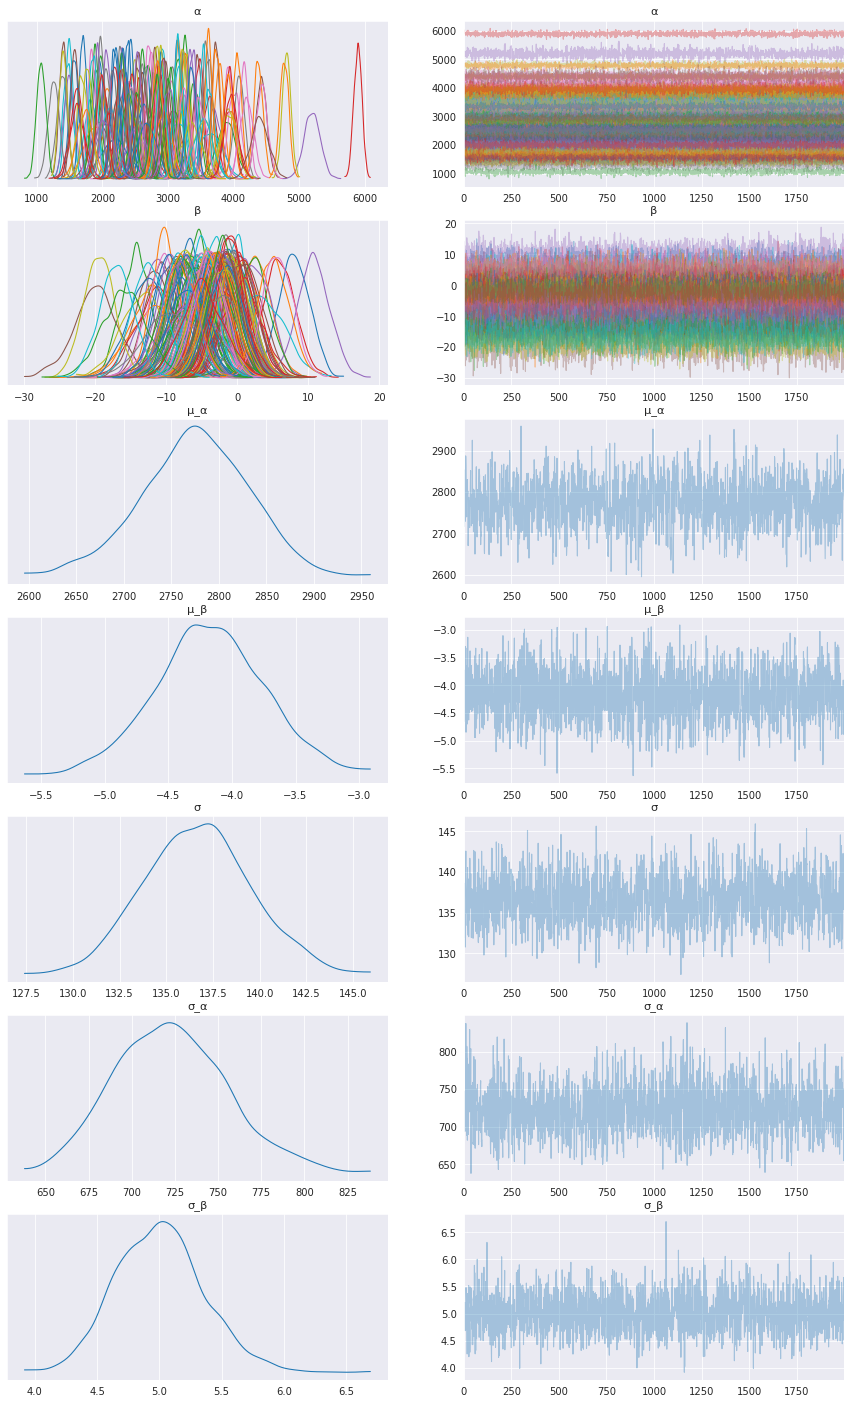

In [9]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));

Looks like our model learned personalized alphas and betas for each patient!

### 4.2. Visualizing FVC decline curves for some patients
Now, let's visually inspect FVC decline curves predicted by our model. We will completely fill in the FVC table, predicting all missing values. The first step is to create a table to fill:

In [10]:
def create_prediction_template(unique_patient_df, weeks_series):
    unique_patient_df["_temp"] = True
    weeks = pd.DataFrame(weeks_series, columns=["Weeks"])
    weeks["_temp"] = True
    return unique_patient_df.merge(weeks, on="_temp").drop(["_temp"], axis=1)

In [11]:
patients = train[["Patient", "patient_code"]].drop_duplicates()
start_week_number = -12
end_week_number = 134
predict_weeks = pd.Series(np.arange(start_week_number, end_week_number))
pred_template = create_prediction_template(patients, predict_weeks)

Predicting the missing values in the FVC table and confidence (sigma) for each value becomes really easy:

In [12]:
patient_code = pred_template["patient_code"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(model, posterior_samples, return_sites=["σ", "obs"])
samples_predictive = predictive(random.PRNGKey(0), patient_code, Weeks, None)

Note that for [`Predictive`](http://num.pyro.ai/en/latest/utilities.html#numpyro.infer.util.Predictive) to work as expected, the response variable of the model (in this case, `FVC_obs`) must be set to `None`.

Let's now put the predictions together with the true values, to visualize them:

In [13]:
df = pred_template.copy()
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df.head()

,Patient,patient_code,Weeks,FVC_pred,sigma,FVC_inf,FVC_sup,FVC_true
0,ID00007637202177411956430,0,-12,2226.545166,160.158493,2066.386719,2386.703613,NaN
1,ID00007637202177411956430,0,-11,2216.172852,160.390778,2055.781982,2376.563721,NaN
2,ID00007637202177411956430,0,-10,2219.136963,155.339615,2063.797363,2374.476562,NaN
3,ID00007637202177411956430,0,-9,2214.727051,153.333313,2061.393799,2368.060303,NaN
4,ID00007637202177411956430,0,-8,2208.758545,157.368637,2051.389893,2366.127197,NaN


Finally, let's see our predictions for 3 patients:

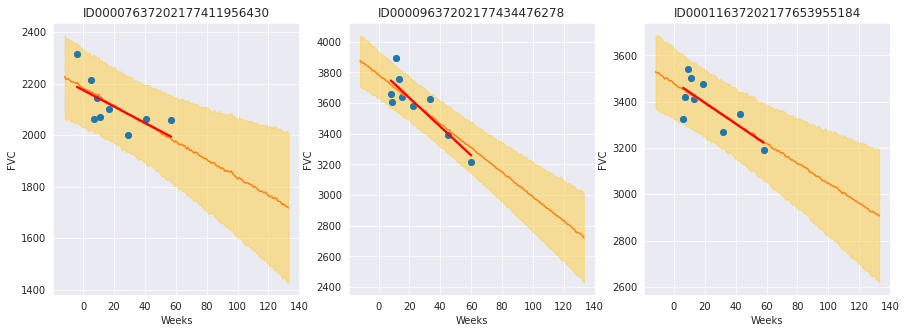

In [14]:
def chart_patient_with_predictions(patient_id, ax):
    data = df[df["Patient"] == patient_id]
    x = data["Weeks"]
    ax.set_title(patient_id)
    ax.plot(x, data["FVC_true"], "o")
    ax.plot(x, data["FVC_pred"])
    ax = sns.regplot(x=x, y=data["FVC_true"], ax=ax, ci=None, line_kws={"color": "red"})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"], alpha=0.5, color="#ffcd3c")
    ax.set_ylabel("FVC")


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient_with_predictions("ID00007637202177411956430", axes[0])
chart_patient_with_predictions("ID00009637202177434476278", axes[1])
chart_patient_with_predictions("ID00011637202177653955184", axes[2])

The results are exactly what we expected to see! Highlight observations:

- The model adequately learned Bayesian Linear Regressions! The orange line (learned predicted FVC mean) is very inline with the red line (deterministic linear regression). But most important: it learned to predict uncertainty, showed in the light orange region (one sigma above and below the mean FVC line)
- The model predicts a higher uncertainty where the data points are more disperse (1st and 3rd patients). Conversely, where the points are closely grouped together (2nd patient), the model predicts a higher confidence (narrower light orange region)
- Finally, in all patients, we can see that the uncertainty grows as the look more into the future: the light orange region widens as the # of weeks grow!

### 4.3. Computing the modified Laplace Log Likelihood and RMSE

As mentioned earlier, the competition was evaluated on a modified version of the Laplace Log Likelihood. In medical applications, it is useful to evaluate a model's confidence in its decisions. Accordingly, the metric is designed to reflect both the accuracy and certainty of each prediction.

For each true FVC measurement, we predicted both an FVC and a confidence measure (standard deviation $\sigma$). The metric was computed as:

\begin{align}
\sigma_{clipped} &= max(\sigma, 70) \\
\delta &= min(|FVC_{true} - FVC_{pred}|, 1000) \\
metric &= -\dfrac{\sqrt{2}\delta}{\sigma_{clipped}} - \ln(\sqrt{2} \sigma_{clipped})
\end{align}

The error was thresholded at 1000 ml to avoid large errors adversely penalizing results, while the confidence values were clipped at 70 ml to reflect the approximate measurement uncertainty in FVC. The final score was calculated by averaging the metric across all (Patient, Week) pairs. Note that metric values will be negative and higher is better.

Next, we calculate the metric and RMSE:

In [15]:
y = df.dropna()
rmse = ((y["FVC_pred"] - y["FVC_true"]) ** 2).mean() ** (1 / 2)
print(f"RMSE: {rmse:.1f} ml")

sigma_c = y["sigma"].values
sigma_c[sigma_c < 70] = 70
delta = (y["FVC_pred"] - y["FVC_true"]).abs()
delta[delta > 1000] = 1000
lll = -np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f"Laplace Log Likelihood: {lll.mean():.4f}")

RMSE: 122.3 ml
Laplace Log Likelihood: -6.1406


What do these numbers mean? It means if you adopted this approach, you would **outperform most of the public solutions** in the competition. Curiously, the vast majority of public solutions adopt a standard deterministic Neural Network, modelling uncertainty through a quantile loss. **Most of the people still adopt a frequentist approach**.

**Uncertainty** for single predictions becomes more and more important in machine learning and is often a requirement. **Especially when the consequences of a wrong prediction are high**, we need to know what the probability distribution of an individual prediction is. For perspective, Kaggle just launched a new competition sponsored by Lyft, to build motion prediction models for self-driving vehicles. "We ask that you predict a few trajectories for every agent **and provide a confidence score for each of them**."

## 5. Add layer to model hierarchy: Smoking Status

We can extend the model by including the column `SmokingStatus` as a pooling level, where model parameters will be partially pooled by the groups "Never smoked", "Ex-smoker", and "Currently smokes".  To do this, we need to:

1. Encode the `SmokingStatus` column
2. Map patient encoding to smoking status encodings
3. Refine and retrain the model with the additional hierarchy

In [16]:
train["SmokingStatus"].value_counts()

Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

In [17]:
patient_code = train["patient_code"].values
Weeks = train["Weeks"].values

In [18]:
smoking_status_encoder = LabelEncoder()
train["smoking_status_code"] = smoking_status_encoder.fit_transform(
    train["SmokingStatus"]
)

smoking_status_code = train["smoking_status_code"].values

In [19]:
map_patient_to_smoking_status = (
    train[["patient_code", "smoking_status_code"]]
    .drop_duplicates()
    .set_index("patient_code", verify_integrity=True)
    .sort_index()["smoking_status_code"]
    .values
)

In [20]:
def model_smoking_hierarchy(
    patient_code, Weeks, map_patient_to_smoking_status, FVC_obs=None
):
    μ_α_global = numpyro.sample("μ_α_global", dist.Normal(0.0, 500.0))
    σ_α_global = numpyro.sample("σ_α_global", dist.HalfNormal(100.0))
    μ_β_global = numpyro.sample("μ_β_global", dist.Normal(0.0, 3.0))
    σ_β_global = numpyro.sample("σ_β_global", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))
    n_smoking_statuses = len(np.unique(map_patient_to_smoking_status))

    with numpyro.plate("plate_smoking_status", n_smoking_statuses):
        μ_α_smoking_status = numpyro.sample(
            "μ_α_smoking_status", dist.Normal(μ_α_global, σ_α_global)
        )
        μ_β_smoking_status = numpyro.sample(
            "μ_β_smoking_status", dist.Normal(μ_β_global, σ_β_global)
        )

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample(
            "α",
            dist.Normal(μ_α_smoking_status[map_patient_to_smoking_status], σ_α_global),
        )
        β = numpyro.sample(
            "β",
            dist.Normal(μ_β_smoking_status[map_patient_to_smoking_status], σ_β_global),
        )

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

### Reparameterize the model

Hierarchical models often need to be reparameterized to enable MCMC to explore the full parameter space.  NumPyro's `LocScaleReparam` is used to do this below.  For more details, see [bad_posterior_geometry.ipynb](https://num.pyro.ai/en/stable/tutorials/bad_posterior_geometry.html) and [funnel.py](https://num.pyro.ai/en/stable/examples/funnel.html).  Thomas Wiecki also has a [great post](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) about developing non-centered models.

In [21]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "μ_α_smoking_status": LocScaleReparam(0),
    "μ_β_smoking_status": LocScaleReparam(0),
    "α": LocScaleReparam(0),
    "β": LocScaleReparam(0),
}
reparam_model_smoking_hierarchy = reparam(
    model_smoking_hierarchy, config=reparam_config
)

In [22]:
nuts_kernel = NUTS(reparam_model_smoking_hierarchy, target_accept_prob=0.97)

mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=5000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, map_patient_to_smoking_status, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|█████████████████████████████████| 8000/8000 [03:55<00:00, 33.99it/s, 1023 steps of size 5.68e-03. acc. prob=0.97]


### 5.1. Inspect the learned parameters

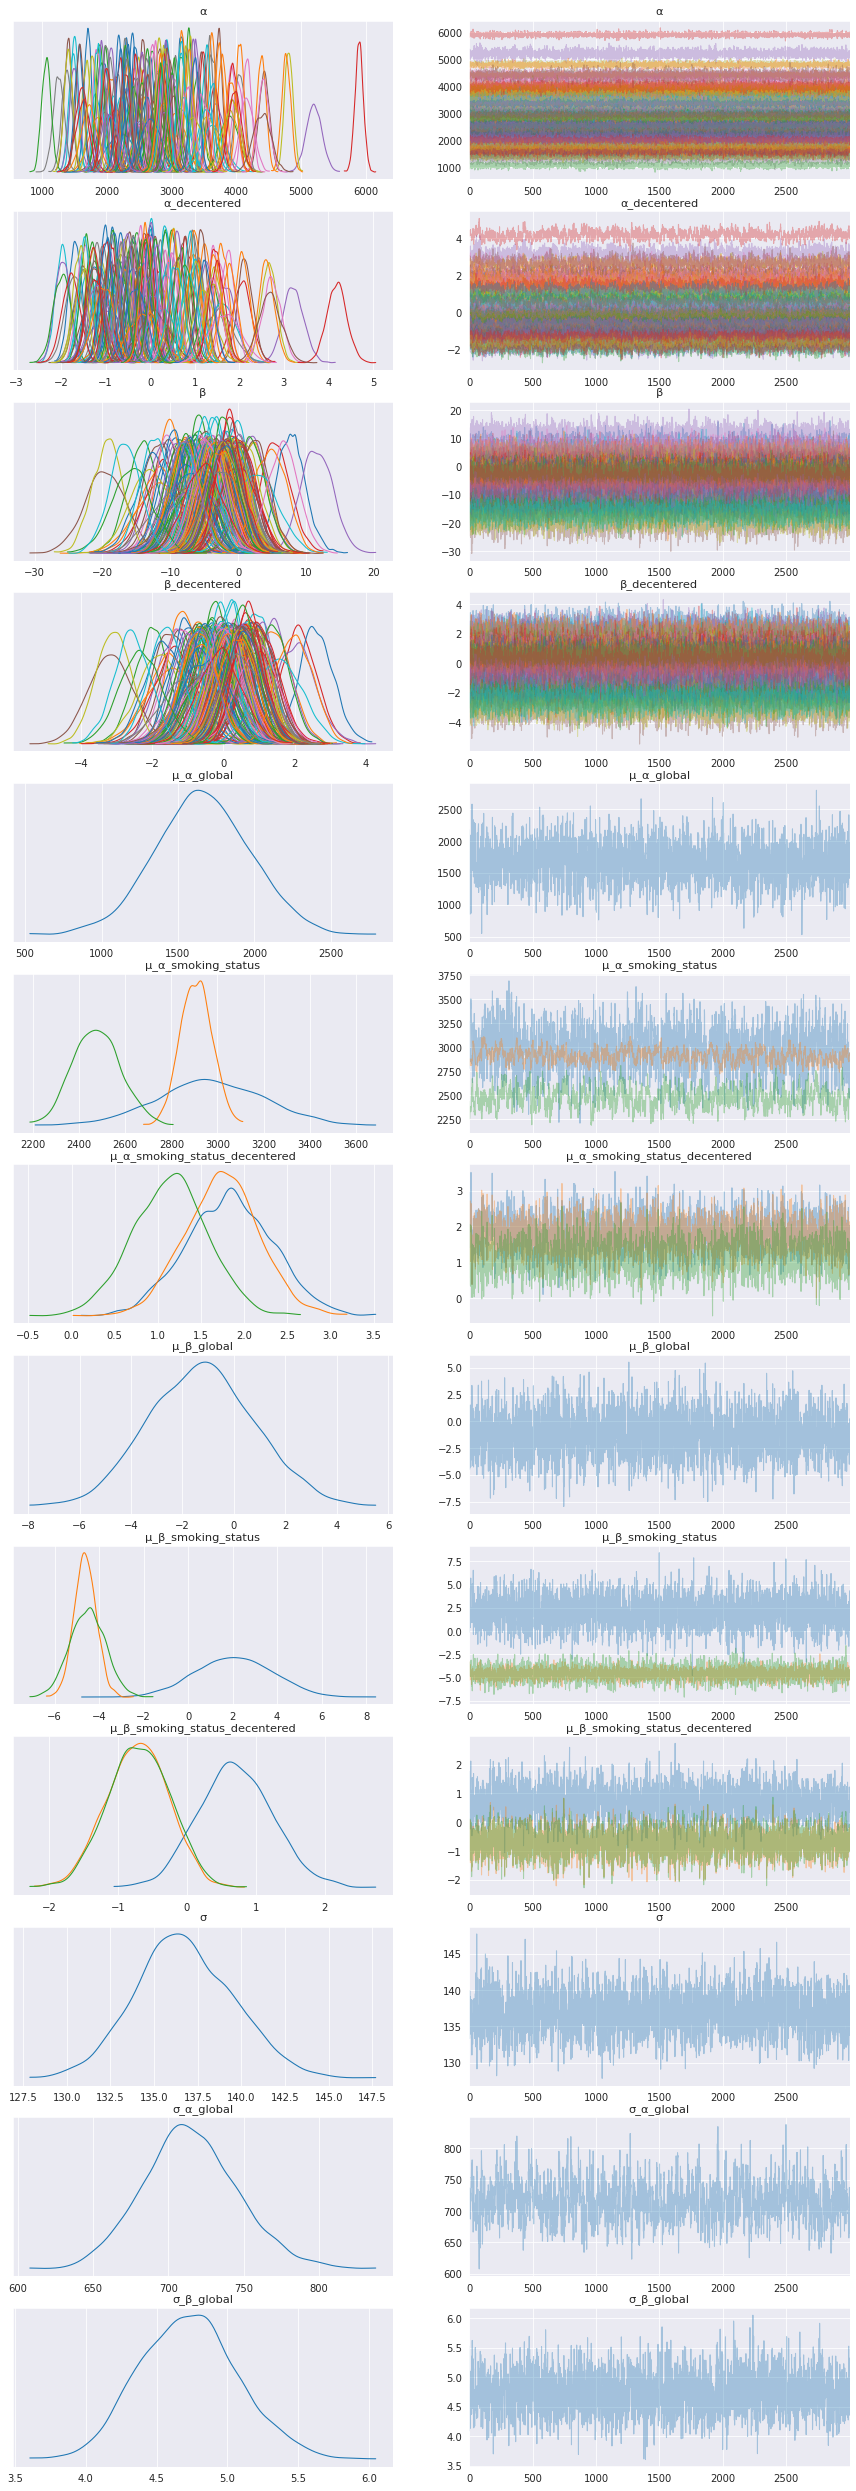

In [23]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 45));

#### Smoking Status distributions

Adding a legend for the smoking status distributions to help interpret the model results for that level.


| Smoking Status    | Code |
|-------------------|------|
| Currently smokes  | 0    |
| Ex-smoker         | 1    |
| Never smoked      | 2    |

In [24]:
# Check the label code for each SmokingStatus
smoking_status_encoder.inverse_transform([0, 1, 2])

array(['Currently smokes', 'Ex-smoker', 'Never smoked'], dtype=object)

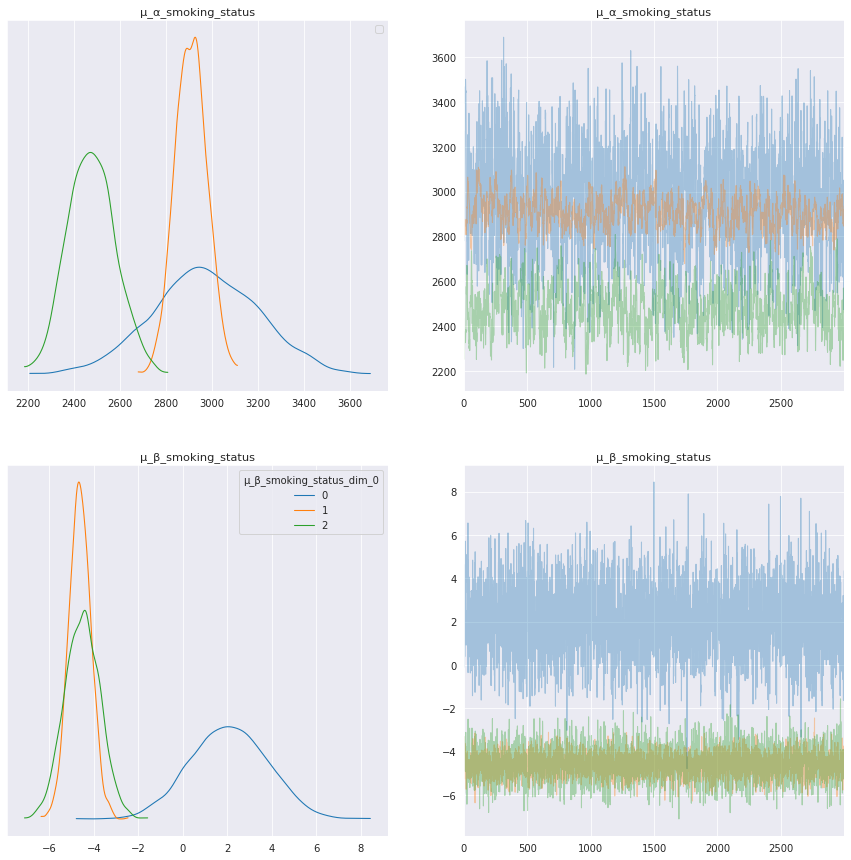

In [25]:
axes = az.plot_trace(
    data,
    var_names=["μ_α_smoking_status", "μ_β_smoking_status"],
    legend=True,
    compact=True,
    figsize=(15, 15),
)
# The legend handles were not working for the first plot
axes[0, 0].legend();

### Interpret smoking status model parameters

The model parameters for each smoking status show interesting results, especially for trend, `μ_β_smoking_status`.  In the trace plots above and summary table below the trend for current smokers, `μ_β_smoking_status[0]`, has a positive mean, whereas the trend for patients that are ex-smokers and those that have never smoked are negative, `μ_β_smoking_status[1]` and `μ_β_smoking_status[2]`.

In [26]:
trace = az.from_numpyro(mcmc)
az.summary(
    trace,
    var_names=["μ_α_global", "μ_β_global", "μ_α_smoking_status", "μ_β_smoking_status"],
)

Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_α_global,1660.172,309.657,1118.038,2274.933,6.589,4.660,2203.0,2086.0,NaN
μ_β_global,-1.252,2.062,-5.014,2.678,0.037,0.035,3040.0,2041.0,NaN
μ_α_smoking_status[0],2970.486,227.761,2572.943,3429.343,7.674,5.452,878.0,1416.0,NaN
μ_α_smoking_status[1],2907.950,68.011,2782.993,3035.172,5.209,3.698,171.0,281.0,NaN
μ_α_smoking_status[2],2475.281,102.948,2286.072,2671.298,6.181,4.381,278.0,566.0,NaN
μ_β_smoking_status[0],2.061,1.713,-1.278,5.072,0.032,0.024,2797.0,2268.0,NaN
μ_β_smoking_status[1],-4.625,0.498,-5.566,-3.721,0.010,0.007,2309.0,2346.0,NaN
μ_β_smoking_status[2],-4.513,0.789,-6.011,-3.056,0.016,0.011,2466.0,2494.0,NaN


Let's look at these curves for individual patients to help interpret these model results.

### 5.2. Visualizing FVC decline curves for some patients

In [27]:
patient_code = pred_template["patient_code"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(
    reparam_model_smoking_hierarchy, posterior_samples, return_sites=["σ", "obs"]
)
samples_predictive = predictive(
    random.PRNGKey(0), patient_code, Weeks, map_patient_to_smoking_status, None
)

In [28]:
df = pred_template.copy()
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df.head()

,Patient,patient_code,Weeks,FVC_pred,sigma,FVC_inf,FVC_sup,FVC_true
0,ID00007637202177411956430,0,-12,2229.098877,157.880753,2071.218018,2386.979736,NaN
1,ID00007637202177411956430,0,-11,2225.022461,157.358429,2067.664062,2382.380859,NaN
2,ID00007637202177411956430,0,-10,2224.487549,155.416016,2069.071533,2379.903564,NaN
3,ID00007637202177411956430,0,-9,2212.780518,154.162155,2058.618408,2366.942627,NaN
4,ID00007637202177411956430,0,-8,2219.202393,154.729507,2064.472900,2373.931885,NaN


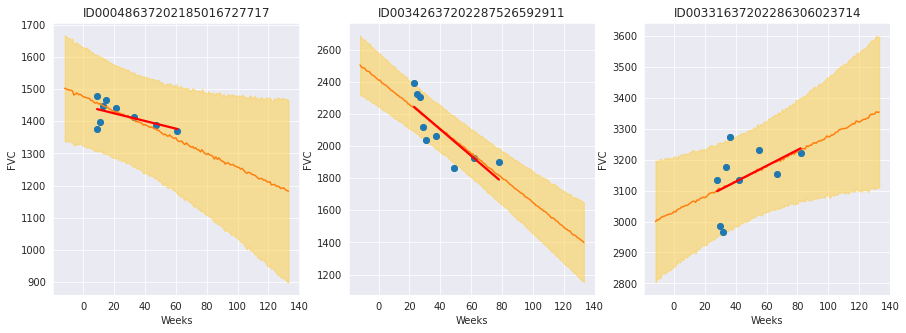

In [29]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient_with_predictions("ID00048637202185016727717", axes[0])  # Never smoked
chart_patient_with_predictions("ID00342637202287526592911", axes[1])  # Ex-smoker
chart_patient_with_predictions("ID00331637202286306023714", axes[2])  # Currently smokes

### Review patients that currently smoke

By plotting each patient with the smoking status "Currently smokes", we see some patients with a clear positive trend and others without a clear trend or negative trend.  The trend lines are less overfit than the unpooled trend lines and show relatively large uncertainty in the slope and intercept.  Depending on the model use case, we could proceed in different ways:

- If we just wanted to get an understanding of different attributes as they relate to patient's FVC over time, we could stop here with an understanding that current smokers might have an increase in FVC over time when being monitored for Pulmonary Fibrosis.  We might hypothesize causes for this observation to design a new experiment to test that hypothesis.
- If we wanted to develop a model that generates predictions used to treat patients, then we will want to make sure we are not overfitting so that we can trust the model with new patients.  We might adjust model parameters to shrink the "Currently smokes" group model parameters to be closer to global parameters or even combine the group with "Ex-smokers".  We could look into collecting more data for current smokers to help ensure the model is not overfitting.

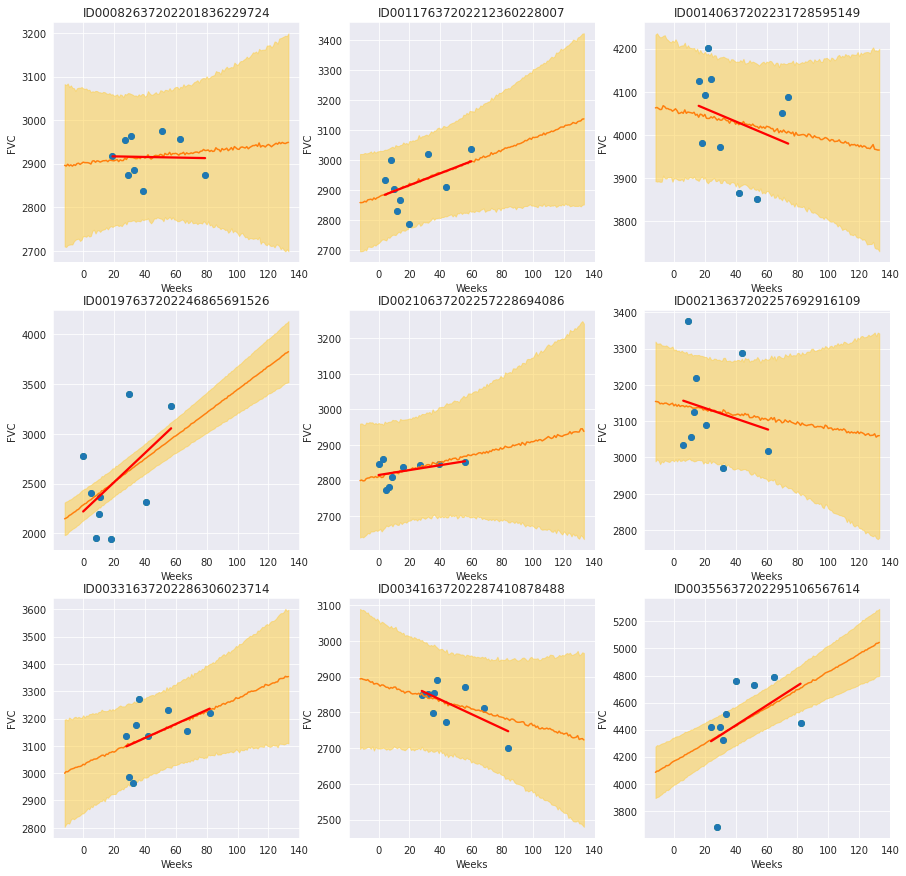

In [30]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, patient in enumerate(
    train[train["SmokingStatus"] == "Currently smokes"]["Patient"].unique()
):
    chart_patient_with_predictions(patient, axes.flatten()[i])

### 5.3 Modified Laplace Log Likelihood and RMSE for model with Smoking Status Level

We calculate the metrics for the updated model and compare to the original model.

In [31]:
y = df.dropna()
rmse = ((y["FVC_pred"] - y["FVC_true"]) ** 2).mean() ** (1 / 2)
print(f"RMSE: {rmse:.1f} ml")

sigma_c = y["sigma"].values
sigma_c[sigma_c < 70] = 70
delta = (y["FVC_pred"] - y["FVC_true"]).abs()
delta[delta > 1000] = 1000
lll = -np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f"Laplace Log Likelihood: {lll.mean():.4f}")

RMSE: 122.6 ml
Laplace Log Likelihood: -6.1420


Both the Laplace Log Likelihood and RMSE show slightly worse performance for the smoking status model.  We've learned that adding this hierarchy level as-is did not improve model performance, but we did find some interested results from the smoking status level that might be worth investigating.  In addition, we might try to adjust priors or trying a different level (e.g. gender) to improve model performance.

## Wrap-up

Finally, I hope the great work done by Pyro/NumPyro developers help democratize Bayesian methods, empowering an ever growing community of researchers and practitioners to create models that can not only generate predictions, but also assess uncertainty in their predictions.

## References

1. Ghahramani, Z. Probabilistic machine learning and artificial intelligence. Nature 521, 452–459 (2015). https://doi.org/10.1038/nature14541

2. Rainforth, Thomas William Gamlen. Automating Inference, Learning, and Design Using Probabilistic Programming. University of Oxford, 2017.